In [1]:
import cv2
import numpy as np
import itertools
from IPython.display import display, Image
import glob

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

files = sorted(glob.glob('../images/manual_trim/*'))
raw_imgs = [cv2.imread(f) for f in files]

In [2]:
import shogicam
import shogicam.util

rect, score = shogicam.corners(raw_imgs[0])

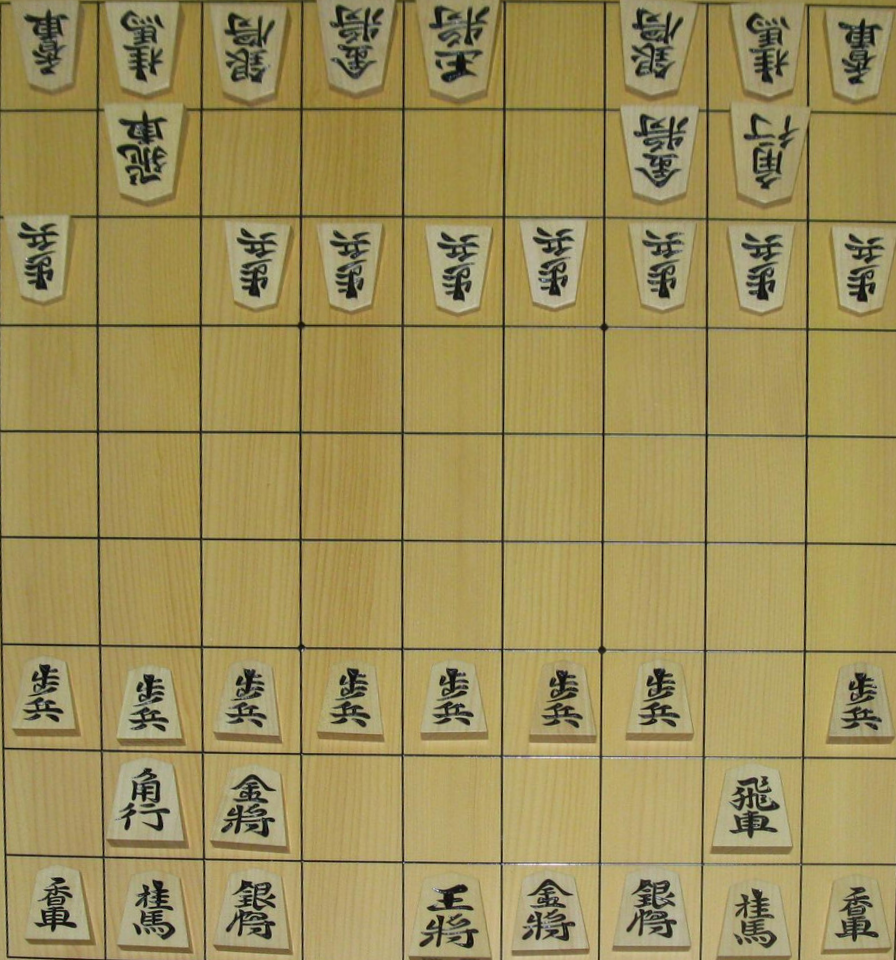

In [3]:
BASE_SIZE = 64
def trim(img, corners, show=True):
    w = BASE_SIZE * 14
    h = BASE_SIZE * 15
    transform = cv2.getPerspectiveTransform(np.float32(corners), np.float32([[0, 0], [w, 0], [w, h], [0, h]]))
    normed = cv2.warpPerspective(img, transform, (w, h))
    if show:
        display_cv_image(normed)
    return normed

img = trim(raw_imgs[0], rect)

In [4]:
img_rows, img_cols = 64, 64
def cells(img):
    dx = img.shape[0] / 9
    dy = img.shape[1] / 9
    for i in range(9):
        for j in range(9):
            sx = int(dx * i)
            sy = int(dy * j)
            yield normalize(img[sx:(int(sx + dx)), sy:(int(sy + dy))], img_rows, img_cols)

# h * w / gray
def normalize(img, h, w):
    size = img.shape[:2]
    f = min(h / size[0], w / size[1])
    resized = cv2.resize(img, (int(size[1] * f), int(size[0] * f)), interpolation=cv2.INTER_AREA)

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blank = np.full((h, w), np.uint8(255), dtype=np.uint8)
    hstart = int((h - gray.shape[0]) / 2)
    wstart = int((w - gray.shape[1]) / 2)
    blank[hstart:(hstart + gray.shape[0]), wstart:(wstart + gray.shape[1])] = gray
    return blank

cell_imgs = np.array(list(cells(img)))
cell_imgs = cell_imgs.reshape(cell_imgs.shape[0], img_rows, img_cols, 1)
cell_imgs = cell_imgs.astype(np.float32)
cell_imgs /= 255
print(cell_imgs.shape)

(81, 64, 64, 1)


In [6]:
from keras.models import load_model
model = load_model("../models/purple.h5")

In [7]:
y = model.predict(cell_imgs)
y_max = np.array([np.argmax(c) for c in y])

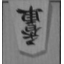

*kyo


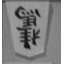

*kei


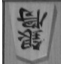

*gin


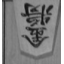

*kin


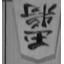

*gyoku


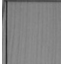

space


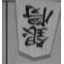

*gin


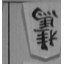

*gin


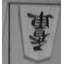

*kyo


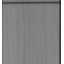

space


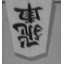

*hi


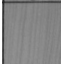

space


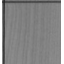

space


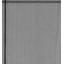

space


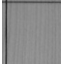

space


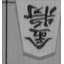

*gin


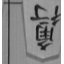

uma


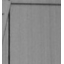

space


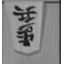

*kei


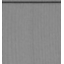

space


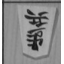

*fu


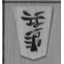

*fu


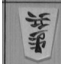

*kaku


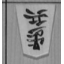

*fu


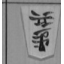

*gin


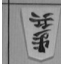

*gin


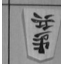

*gin


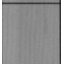

space


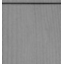

space


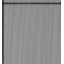

space


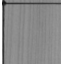

space


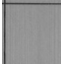

space


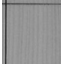

space


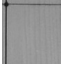

space


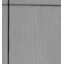

space


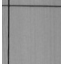

space


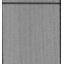

space


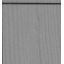

space


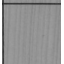

space


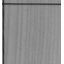

space


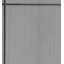

space


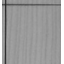

space


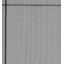

space


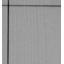

space


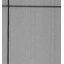

space


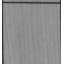

space


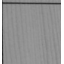

space


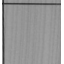

space


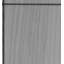

space


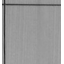

space


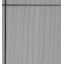

space


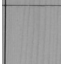

space


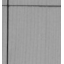

space


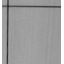

space


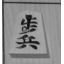

fu


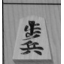

fu


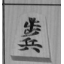

fu


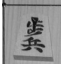

fu


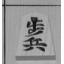

fu


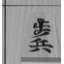

uma


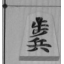

kei


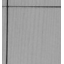

space


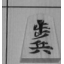

uma


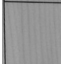

space


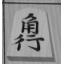

kaku


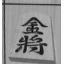

kin


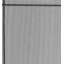

space


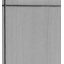

space


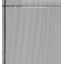

space


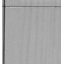

space


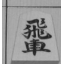

ryu


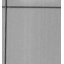

space


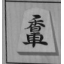

kei


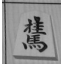

kei


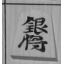

gin


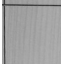

space


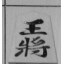

ou


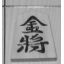

kin


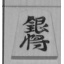

gin


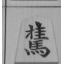

kin


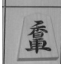

kei


In [8]:
labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
def label_name(idx):
    if len(labels) > idx:
        return labels[idx]
    elif len(labels) * 2 > idx:
        return "*" + labels[idx - len(labels)]
    else:
        return "space"

for i in range(len(cell_imgs)):
    display_cv_image(np.uint8(cell_imgs[i] * 255)[:, :, 0])
    print(label_name(y_max[i]))